In [1]:
from mosaic.cells.video import VideoCell


In [2]:
import cv2
import torchvision.transforms.functional as F

fname = "/dfs/scratch1/tchang97/hmdb51_all/hmdb51/clap/The_Slow_Clap_clap_u_nm_np1_fr_med_24.avi"
cell = VideoCell(fname, 80, 1, random_clip_start=False)

# things to test
# filepath
#     bad filepath
#     corrupted filepath
# clip_length
#     bad clip length
#     too long clip length - OK (switches to padding)
# n_clips
#     bad number of clips
#     crap ton of clips (> n_frames)
# transform
#     choose some arbitray crap from torchvision
# clip_sampling
#    equal_segment (default) - OK
#    anywhere
# downsample_ratio
#    test 2
#    test something ridiculous
#    test < 1
#    test 0 and negatives -- need to reject those
# random_clip_start
#    test True - OK
#    test False - OK
# time_dim
#    test a few settings (0, 1)
# stack_clips
#    test proper shapes w/ torch.cat - OK
#    test proper shapes w/ torch.stack - OK

In [ ]:
class TemporalDownsampling(object):
    def __init__(self, downsample_factor: int):
        self.downsample_factor = downsample_factor
        if self.downsample_factor != int(self.downsample_factor):
            raise ValueError("Fractional downsampling not supported.")
        if self.downsample_factor < 1:
            raise ValueError("Downsampling must be by a factor of 1 (no downsampling) or greater.")

    def __call__(self, video: torch.Tensor, time_dim: Optional[int] = 1) -> torch.Tensor:
        video_length = video.size(time_dim)
        downsampled_indices = torch.arange(0, video_length, self.downsample_ratio).long()
        frames = torch.index_select(frames, self.time_dim, downsampled_indices)
        return frames
        
        
class TemporalCrop(object):
    def __init__(self,
                 n_clips: int,
                 clip_length: int,
                 clip_spacing: Optional[str] = "equal",
                 padding_mode: Optional[str] = "loop",
                 stack_clips: Optional[bool] = True):
        self.n_clips = n_clips
        self.clip_length = clip_length
        self.clip_spacing = clip_spacing
        self.padding_mode = padding_mode
        self.stack_clips = stack_clips
        
        assert clip_spacing in ["equal", "anywhere"]
        assert padding_mode in ["loop", "freeze"]
        
    def _get_sampling_boundaries(self, video_length: int, clip_number: int) -> Tuple[int, int]:
        if self.clip_spacing == "equal_segment":
            start = int(clip_number / self.n_clips * video_length)
            end = int((clip_number + 1) / self.n_clips * video_length)
        else: # self.clip_spacing == "anywhere"
            start = 0
            end = video_length
        return start, end

    def _build_indices(self, start: int, length: int) -> torch.LongTensor:
        vanilla_indices = torch.arange(start, start + self.clip_length)
        if vanilla_indices.max().item() >= length:
            if self.padding_mode == "loop":
                vanilla_indices %= length
            else: # self.padding_mode == "freeze":
                vanilla_indices[vanilla_indices >= length] = length - 1
        return vanilla_indices

    def __call__(self,
                 video: torch.Tensor,
                 time_dim: Optional[int] = 1,
                 return_indices: Optional[bool] = False) -> torch.Tensor:
        video_length = video.size(time_dim)
        clips = []
        if return_indices:
            frame_indices = []
        for clip_number in range(self.n_clips):
            start, end = self._get_sampling_boundaries(video_length, clip_number)
            if self.random_clip_start:
                first_frame = random.randint(start, end - self.clip_length)
            else:
                first_frame = start
            indices = self._build_indices(first_frame, len(frames))
            if return_indices:
                frame_indices.append(indices.numpy())
            clip = torch.index_select(frames, time_dim, indices)
            clips.append(clip)
        if self.stack_clips:  # new dim. for clips (n_clips, channel, duration, height, width)
            all_clips = torch.stack(clips, dim=0)
        else:  # concatenate clips in time dimension (channel, n_clips * duration, height, width)
            all_clips = torch.cat(clips, dim=time_dim)
        if return_indices:
            return all_clips, frame_indices
        else:
            return all_clips

In [3]:
vid = cell.get()
vid.size()

torch.Size([1, 3, 80, 240, 320])

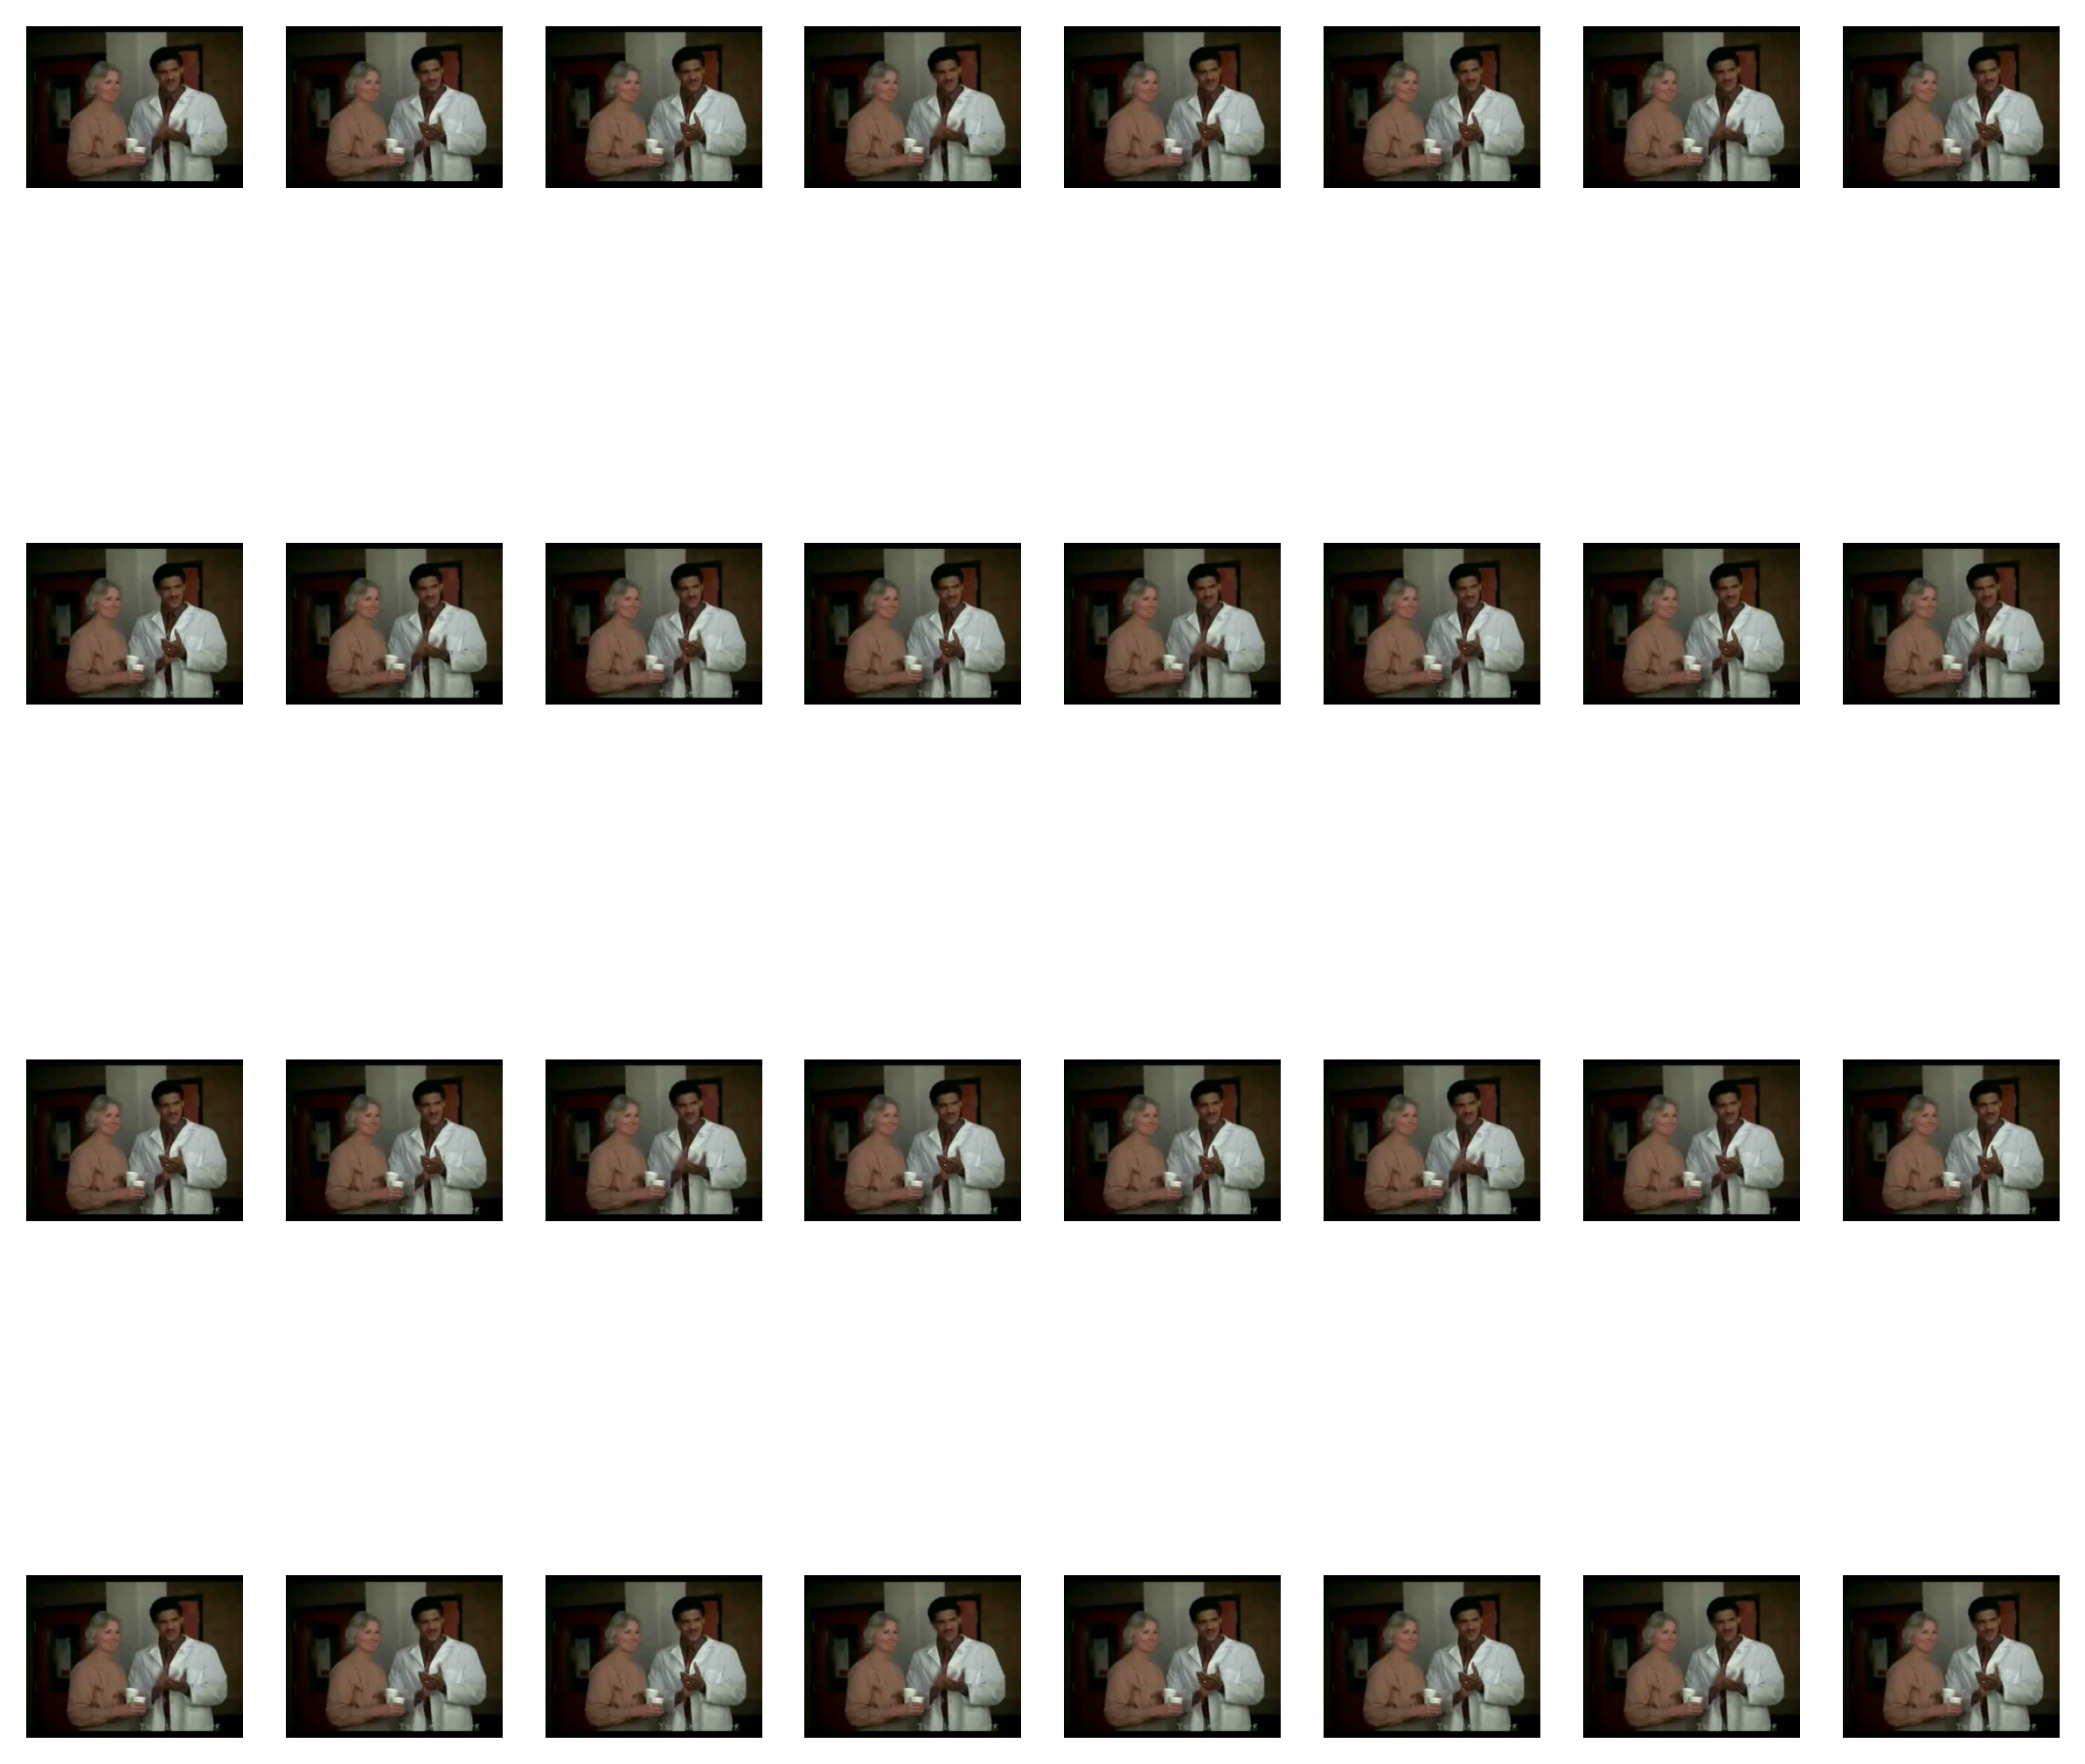

In [4]:
import matplotlib.pyplot as plt
import torch
fig, axs = plt.subplots(4, 8, figsize=(10, 10), dpi=300)
axs = axs.ravel()

for (ax, img) in zip(axs, torch.split(vid, 1, dim=2)):
    ax.imshow(img.squeeze().permute(1, 2, 0).detach().numpy())
    ax.set_axis_off()

In [5]:
cell.frame_indices

In [24]:
b

tensor([16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,  0,  1,  2,  3,  4])